In [3]:
!pip install gurobipy


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import gurobipy as gp

In [5]:
import os
import gurobipy as gp
from gurobipy import GRB, quicksum

params = {
    "WLSACCESSID": os.getenv("GRB_WLSACCESSID", '35a382ab-2f66-4f8c-93e5-29e3ae8a72c9'),
    "WLSSECRET":   os.getenv("GRB_WLSSECRET",   '697d9c6e-319b-4535-8f62-9fd78101f77d'),
    "LICENSEID":   int(os.getenv("GRB_LICENSEID", "2610074")),
    # optional quality-of-life settings:
    "OutputFlag":  0,          # silence logs for cleaner notebooks
    "CSClientLog": 0,          # silence WLS client logs
}
env = gp.Env(params=params)
env.start()
print("Gurobi environment ready.")


Gurobi environment ready.


In [6]:
!pip install yfinance --upgrade --no-cache-dir


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import yfinance as yf
from gurobipy import GRB

C:\Users\andyl\AppData\Local\Temp\ipykernel_22184\1222083959.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [10]:
# Data Collection

def get_nasdaq100_tickers():

    url = 'https://en.wikipedia.org/wiki/Nasdaq-100'
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) '
                             'AppleWebKit/537.36 (KHTML, like Gecko) '
                             'Chrome/120.0.0.0 Safari/537.36'}

    response = requests.get(url, headers=headers)
    response.raise_for_status()  # Raises an HTTPError if status != 200

    tables = pd.read_html(response.text)

    for table in tables:
      if 'Ticker' in table.columns:
        tickers = table['Ticker'].tolist()

        tickers = [str(ticker).strip() for ticker in tickers
                  if pd.notna(ticker) and ticker != 'nan']
    print(tickers)

    return tickers

tickers = get_nasdaq100_tickers()

def download_data(tickers, start_date, end_date):
    """Download stock price data and calculate returns."""
    # Download data
    data = yf.download(tickers, start=start_date, end=end_date, 
                       progress=False, auto_adjust=False)
    
    prices = data['Adj Close']

    # Forward fill and backward fill to handle missing days
    prices = prices.ffill().bfill()
    
    # Drop columns with any remaining NaN values (stocks that couldn't be filled)
    prices = prices.dropna(axis=1)
    # Calculate returns
    returns = prices.pct_change().dropna()
    
    return prices, returns


def calculate_returns(prices):

    returns = prices.pct_change().dropna()
    return returns

['ADBE', 'AMD', 'ABNB', 'GOOGL', 'GOOG', 'AMZN', 'AEP', 'AMGN', 'ADI', 'AAPL', 'AMAT', 'APP', 'ARM', 'ASML', 'AZN', 'TEAM', 'ADSK', 'ADP', 'AXON', 'BKR', 'BIIB', 'BKNG', 'AVGO', 'CDNS', 'CDW', 'CHTR', 'CTAS', 'CSCO', 'CCEP', 'CTSH', 'CMCSA', 'CEG', 'CPRT', 'CSGP', 'COST', 'CRWD', 'CSX', 'DDOG', 'DXCM', 'FANG', 'DASH', 'EA', 'EXC', 'FAST', 'FTNT', 'GEHC', 'GILD', 'GFS', 'HON', 'IDXX', 'INTC', 'INTU', 'ISRG', 'KDP', 'KLAC', 'KHC', 'LRCX', 'LIN', 'LULU', 'MAR', 'MRVL', 'MELI', 'META', 'MCHP', 'MU', 'MSFT', 'MSTR', 'MDLZ', 'MNST', 'NFLX', 'NVDA', 'NXPI', 'ORLY', 'ODFL', 'ON', 'PCAR', 'PLTR', 'PANW', 'PAYX', 'PYPL', 'PDD', 'PEP', 'QCOM', 'REGN', 'ROP', 'ROST', 'SHOP', 'SOLS', 'SBUX', 'SNPS', 'TMUS', 'TTWO', 'TSLA', 'TXN', 'TRI', 'TTD', 'VRSK', 'VRTX', 'WBD', 'WDAY', 'XEL', 'ZS']


C:\Users\andyl\AppData\Local\Temp\ipykernel_22184\69914861.py:13: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(response.text)


In [11]:
prev_prices, prev_returns = download_data(tickers, '2024-01-01', '2024-12-30')
curr_prices, curr_returns = download_data(tickers, '2025-01-01', '2025-10-17')

index_ticker = "^NDX"

prev_index_prices, prev_index_returns = download_data(index_ticker, '2024-01-01', '2024-12-30')
curr_index_prices, curr_index_returns = download_data(index_ticker, '2025-01-01', '2025-10-17')



1 Failed download:
['SOLS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2024-01-01 -> 2024-12-30) (Yahoo error = "Data doesn\'t exist for startDate = 1704085200, endDate = 1735534800")')

1 Failed download:
['SOLS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-01-01 -> 2025-10-17) (Yahoo error = "Data doesn\'t exist for startDate = 1735707600, endDate = 1760673600")')


In [12]:
prev_returns = prev_returns.loc[prev_returns.index.intersection(prev_index_returns.index)]
curr_returns = curr_returns.loc[curr_returns.index.intersection(curr_index_returns.index)]

q_2024 = prev_index_returns.loc[prev_returns.index, "^NDX"]
q_2025 = curr_index_returns.loc[curr_returns.index, "^NDX"]

In [13]:
def select_m_stocks_by_IP(rho, m, tickers, env, verbose=False):
    """
    IP:
      max sum_{i,j} rho_ij * x_ij
      s.t. sum_j y_j = m
           sum_j x_ij = 1          ∀i
           x_ij <= y_j             ∀i,j
           x_ij, y_j ∈ {0,1}
    """
    n = rho.shape[0]
    mdl = gp.Model("stock_selection", env=env)
    if not verbose:
        mdl.Params.OutputFlag = 0

    #decision variables
    x = mdl.addVars(n, n, vtype=GRB.BINARY, name="x")  # x[i,j]
    y = mdl.addVars(n, vtype=GRB.BINARY, name="y")     # y[j]

    mdl.setObjective(quicksum(rho[i, j]*x[i, j] for i in range(n) for j in range(n)), GRB.MAXIMIZE)
    mdl.addConstr(quicksum(y[j] for j in range(n)) == m, name="choose_m")

    for i in range(n):
        mdl.addConstr(quicksum(x[i, j] for j in range(n)) == 1, name=f"assign_{i}")

    for i in range(n):
        for j in range(n):
            mdl.addConstr(x[i, j] <= y[j], name=f"link_{i}_{j}")

    mdl.optimize()

    selected_idx = [j for j in range(n) if y[j].X > 0.5]
    selected_tickers = [tickers[j] for j in selected_idx]
    rep_of_i = [max(range(n), key=lambda j: x[i, j].X) for i in range(n)]
    return selected_idx, selected_tickers, rep_of_i


In [14]:
import numpy as np

def fit_weights_L1(R, q, sel_idx, env, nonneg=True, verbose=False):
    """
    Minimize sum_t | q_t - sum_j w_j R[t,j] |
    s.t. sum w = 1, w >= 0 (if nonneg)
    """
    T, N = R.shape
    J = sel_idx
    mdl = gp.Model("weight_fit_L1", env=env)
    if not verbose:
        mdl.Params.OutputFlag = 0

    w = mdl.addVars(J, lb=0.0 if nonneg else -GRB.INFINITY, name="w")
    e = mdl.addVars(T, lb=0.0, name="e")

    for t in range(T):
        mdl.addConstr(e[t] >= q[t] - quicksum(w[j]*R[t, j] for j in J))
        mdl.addConstr(e[t] >= -q[t] + quicksum(w[j]*R[t, j] for j in J))

    mdl.addConstr(quicksum(w[j] for j in J) == 1.0, name="budget")
    mdl.setObjective(quicksum(e[t] for t in range(T)), GRB.MINIMIZE)
    mdl.optimize()

    w_full = np.zeros(N)
    for j in J:
        w_full[j] = w[j].X
    L1 = sum(e[t].X for t in range(T))
    return w_full, L1


In [15]:
rho = prev_returns.corr().fillna(0).clip(-1,1).values
tickers = list(prev_returns.columns)
sel_idx, sel_tickers, rep = select_m_stocks_by_IP(rho, m=5, tickers=tickers, env=env)

R24 = prev_returns.values   # T24 x N
R25 = curr_returns.values   # T25 x N
q24 = q_2024.values      # T24
q25 = q_2025.values      # T25

print(R24)

w_full_2024, in_sample_L1 = fit_weights_L1(R24, q24, sel_idx,  env=env, nonneg=True)

# out-of-sample L1 on 2025
pred25 = R25 @ w_full_2024
oos_L1 = np.sum(np.abs(q25 - pred25))
print(f"In-sample L1 (2024): {in_sample_L1:.6f}")
print(f"Out-of-sample L1 (2025): {oos_L1:.6f}")


[[-0.00748759 -0.0078822  -0.01427419 ...  0.00048459  0.00173317
  -0.01002962]
 [-0.01270015  0.00224856 -0.00828974 ... -0.00495517  0.00235922
   0.00042806]
 [-0.004013    0.01690095 -0.00432063 ... -0.00479257  0.
  -0.00247233]
 ...
 [ 0.01147809  0.00349391  0.00268615 ...  0.01375332  0.0072356
   0.00709902]
 [ 0.00317563  0.00244464  0.00495602 ...  0.00126374 -0.00043973
   0.00197592]
 [-0.01324214 -0.01429953 -0.00817485 ... -0.01165645 -0.00058664
  -0.01636203]]
In-sample L1 (2024): 0.961256
Out-of-sample L1 (2025): 0.879061


In [16]:
results = []
for m in [5,10,20,30,40,50,60,70,80,90,100]:
    if m < R24.shape[1]:
        sel_idx, sel_tickers, rep = select_m_stocks_by_IP(rho, m, tickers, env=env)
    else:
        sel_idx = list(range(R24.shape[1]))

    w_full_2024, L1_2024 = fit_weights_L1(R24, q24, sel_idx, env=env, nonneg=True)
    L1_2025 = float(np.sum(np.abs(q25 - R25 @ w_full_2024)))
    results.append({"m": m, "L1_2024": L1_2024, "L1_2025": L1_2025})


In [ ]:
print(results)

#print results more detailed

# Create detailed results table by m value
df_results = pd.DataFrame(results)
df_results.to_csv('results.csv', index=False)

# Create summary table with one row per m value
results_summary = df_results[['m', 'L1_2024', 'L1_2025']].copy()
results_summary.columns = ['m', 'In-Sample L1 (2024)', 'Out-of-Sample L1 (2025)']

print("\n" + "="*70)
print("PERFORMANCE SUMMARY BY NUMBER OF STOCKS (m)")
print("="*70)
print(results_summary.to_string(index=False))
print("\nInterpretation:")
print("  • In-Sample L1 (2024): Model trained and tested on 2024 data")
print("  • Out-of-Sample L1 (2025): Model trained on 2024, tested on 2025 data")
print("="*70)


[{'m': 5, 'L1_2024': 0.9612555448468324, 'L1_2025': 0.8790613568629372}, {'m': 10, 'L1_2024': 0.9448138589750981, 'L1_2025': 0.8433885117400997}, {'m': 20, 'L1_2024': 0.7656501094883166, 'L1_2025': 0.6632460991508553}, {'m': 30, 'L1_2024': 0.7161949509774365, 'L1_2025': 0.6555659389260395}, {'m': 40, 'L1_2024': 0.6291748926928312, 'L1_2025': 0.6369628229462931}, {'m': 50, 'L1_2024': 0.5986436787958015, 'L1_2025': 0.5726180561089118}, {'m': 60, 'L1_2024': 0.5470096654790608, 'L1_2025': 0.5248023763326359}, {'m': 70, 'L1_2024': 0.5005321000384656, 'L1_2025': 0.5128650004151929}, {'m': 80, 'L1_2024': 0.4681704753248469, 'L1_2025': 0.5307841100837023}, {'m': 90, 'L1_2024': 0.10888031286087951, 'L1_2025': 0.22265300543222977}, {'m': 100, 'L1_2024': 0.09525592279991205, 'L1_2025': 0.21379613392018854}]

PERFORMANCE SUMMARY BY NUMBER OF STOCKS (m)
  m  In-Sample L1 (2024)  Out-of-Sample L1 (2025)
  5             0.961256                 0.879061
 10             0.944814                 0.8433

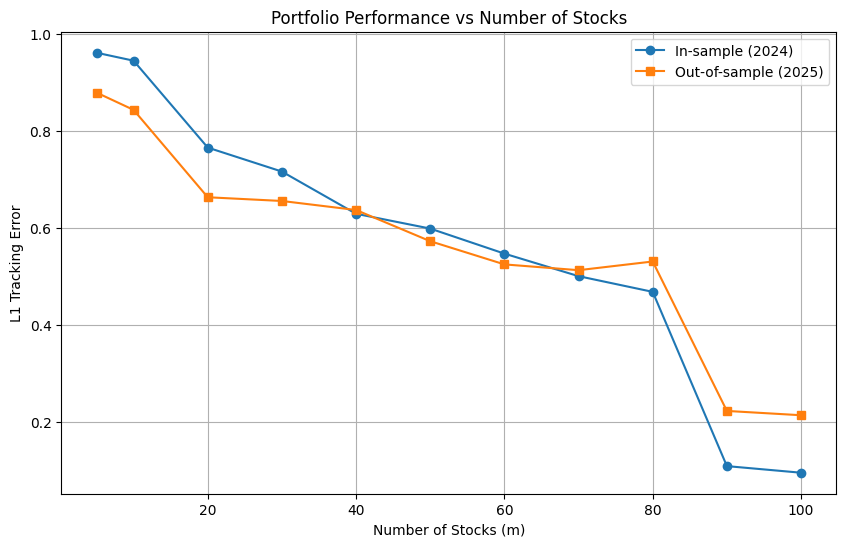

In [18]:
# After computing results for all m values
df_results = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
plt.plot(df_results['m'], df_results['L1_2024'], marker='o', label='In-sample (2024)')
plt.plot(df_results['m'], df_results['L1_2025'], marker='s', label='Out-of-sample (2025)')
plt.xlabel('Number of Stocks (m)')
plt.ylabel('L1 Tracking Error')
plt.title('Portfolio Performance vs Number of Stocks')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
def fit_sparse_weights_MIP_L1(rets_mat: np.ndarray, q_vec: np.ndarray, m: int, env, time_limit_sec=3600, nonneg=True, verbose=False):
    T, N = rets_mat.shape
    mdl = gp.Model("sparse_weight_fit_L1", env=env)
    mdl.Params.OutputFlag = 1 if verbose else 0
    mdl.Params.TimeLimit = time_limit_sec

    # Vars
    w = mdl.addVars(N, lb=0.0 if nonneg else -GRB.INFINITY, name="w")
    y = mdl.addVars(N, vtype=GRB.BINARY, name="y")
    e = mdl.addVars(T, lb=0.0, name="e")

    # abs value linearization
    for t in range(T):
        mdl.addConstr(e[t] >= q_vec[t] - gp.quicksum(w[j] * rets_mat[t, j] for j in range(N)))
        mdl.addConstr(e[t] >= -q_vec[t] + gp.quicksum(w[j] * rets_mat[t, j] for j in range(N)))

    # budget + sparsity
    mdl.addConstr(gp.quicksum(w[j] for j in range(N)) == 1.0)
    mdl.addConstr(gp.quicksum(y[j] for j in range(N)) == m)

    # big-M linking (M=1 is tight under nonneg + budget)
    M = 1.0
    for j in range(N):
        mdl.addConstr(w[j] <= M * y[j])

    mdl.setObjective(gp.quicksum(e[t] for t in range(T)), GRB.MINIMIZE)
    mdl.optimize()

    w_sol = np.array([w[j].X for j in range(N)])
    sel_idx = [j for j in range(N) if y[j].X > 0.5]
    total_L1 = sum(e[t].X for t in range(T))
    return w_sol, sel_idx, total_L1

In [ ]:

GUROBI_TIME_LIMIT = 10  # Time limit per m value (seconds)
M_VALUES = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
RESULTS_FILE = "mip_results.json"

import json
import os

# Load existing results if available
mip_results = {}
if os.path.exists(RESULTS_FILE):
    print(f"Loading existing results from {RESULTS_FILE}")
    with open(RESULTS_FILE, 'r') as f:
        data = json.load(f)
        mip_results = data.get('results', {})
        print(f"Found {len(mip_results)} existing results")

# Run MIP optimization for all m values
print(f"\nStarting MIP optimization (time limit: {GUROBI_TIME_LIMIT}s per m)")
print("="*70)

for m in M_VALUES:
    m_key = str(m)
    
    # Skip if already computed
    if m_key in mip_results and mip_results[m_key].get('L1_2024') is not None:
        print(f"m={m}: Skipping (already computed)")
        continue
    
    # Skip if m >= number of stocks
    if m >= R24.shape[1]:
        print(f"m={m}: Skipping (m >= number of stocks)")
        continue
    
    print(f"\nm={m}: Optimizing (time limit: {GUROBI_TIME_LIMIT}s)...")
    
    # Run MIP optimization
    w_mip, sel_idx_mip, L1_2024 = fit_sparse_weights_MIP_L1(
        R24, q24, m, env=env, time_limit_sec=GUROBI_TIME_LIMIT, nonneg=True
    )
    
    # Evaluate on 2025 data
    L1_2025 = float(np.sum(np.abs(q25 - R25 @ w_mip)))
    
    # Store results
    mip_results[m_key] = {
        "m": m,
        "L1_2024": float(L1_2024),
        "L1_2025": float(L1_2025),
        "selected_indices": sel_idx_mip,
        "selected_tickers": [tickers[i] for i in sel_idx_mip],
        "weights": w_mip.tolist()
    }
    
    print(f"  Completed: L1_2024={L1_2024:.6f}, L1_2025={L1_2025:.6f}")
    
    # Save results incrementally
    results_full = {
        "metadata": {
            "time_limit_per_m": GUROBI_TIME_LIMIT,
            "m_values": M_VALUES
        },
        "data_info": {
            "num_stocks": len(tickers),
            "num_days_2024": len(R24),
            "num_days_2025": len(R25)
        },
        "results": mip_results
    }
    with open(RESULTS_FILE, 'w') as f:
        json.dump(results_full, f, indent=2)

print("\n" + "="*70)
print("MIP Optimization Complete!")
print(f"Results saved to: {RESULTS_FILE}")

# Display summary
df_mip = pd.DataFrame([mip_results[str(m)] for m in M_VALUES if str(m) in mip_results])
if not df_mip.empty:
    print("\nMIP Results Summary:")
    print(df_mip[['m', 'L1_2024', 'L1_2025']].to_string(index=False))



Starting MIP optimization (time limit: 10s per m)

m=5: Optimizing (time limit: 10s)...
  Completed: L1_2024=0.758054, L1_2025=0.724923

m=10: Optimizing (time limit: 10s)...
  Completed: L1_2024=0.484755, L1_2025=0.504937

m=20: Optimizing (time limit: 10s)...
  Completed: L1_2024=0.303915, L1_2025=0.380599

m=30: Optimizing (time limit: 10s)...
  Completed: L1_2024=0.234559, L1_2025=0.326502

m=40: Optimizing (time limit: 10s)...
  Completed: L1_2024=0.166702, L1_2025=0.270962

m=50: Optimizing (time limit: 10s)...
  Completed: L1_2024=0.135256, L1_2025=0.244725

m=60: Optimizing (time limit: 10s)...
  Completed: L1_2024=0.114366, L1_2025=0.234787

m=70: Optimizing (time limit: 10s)...
  Completed: L1_2024=0.109776, L1_2025=0.225796

m=80: Optimizing (time limit: 10s)...
  Completed: L1_2024=0.096695, L1_2025=0.228574

m=90: Optimizing (time limit: 10s)...
  Completed: L1_2024=0.094411, L1_2025=0.217221

m=100: Optimizing (time limit: 10s)...
  Completed: L1_2024=0.094411, L1_2025=0